# Importing the needed libraries

In [1]:
from tqdm import tqdm
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root
from scipy.stats import binned_statistic

G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun
headers = {"api-key": '81b7c70637fa8b110e6b9f236ea07c37'}
box_size = 75 * 1e3 / h # kpc
a = 1 # scale factor
z = 0 # Redshift

R_bins = np.geomspace(1, 100, 20)

# Custom Functions

In [6]:
def NFW_mass(r, M200, c200):
    """
    Calcula la masa acumulada para un perfil NFW
    
    Parámetros:
    -----------
    r : array
        Radio en kpc
    M200 : float 
        Masa total del halo en Msun
    c200 : float
        Parámetro de concentración
        
    Retorna:
    --------
    M : array
        Masa acumulada en Msun
    """
    # Constantes
    G = 4.302e-6  # kpc (km/s)^2 Msun^-1
    H = 67.74     # km/s/Mpc
    rho_crit = 3 * H**2 / (8 * np.pi * G) * 1e-6  # Msun/kpc^3
    
    # Radio característico
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)
    rs = r200 / c200
    
    # Función g(c)
    gc = np.log(1 + c200) - c200/(1 + c200)
    
    return M200 * (np.log(1 + r/rs) - (r/rs)/(1 + r/rs)) / gc

In [7]:
# Función para ajustar
def fit_NFW(r, mass):
    """
    Ajusta un perfil NFW a los datos
    
    Parámetros:
    -----------
    r : array
        Radio en kpc
    mass : array
        Masa acumulada en Msun
        
    Retorna:
    --------
    M200 : float
        Masa total del halo en Msun
    c200 : float 
        Parámetro de concentración
    """
    # Eliminar valores nulos o negativos
    mask = (mass > 0)
    r = r[mask]
    mass = mass[mask]
    
    # Función a minimizar
    def chi2(params):
        M200, c200 = params
        model = NFW_mass(r, M200, c200)
        return np.sum((np.log10(mass) - np.log10(model))**2)
    
    # Valores iniciales
    M200_init = np.max(mass) * 1.5
    c200_init = 10
    
    # Ajuste
    from scipy.optimize import minimize
    result = minimize(chi2, [M200_init, c200_init], 
                     bounds=[(1e10, 1e15), (1, 100)])
    
    return result.x

In [8]:
def mass_to_density(r, mass):
    """
    Convierte masa acumulada a densidad
    
    Parámetros:
    -----------
    r : array
        Radio en kpc
    mass : array
        Masa acumulada en Msun
        
    Retorna:
    --------
    rho_mean : array
        Densidad media en Msun/kpc³
    rho_local : array
        Densidad local en Msun/kpc³
    """
    # Densidad media
    volume = 4/3 * np.pi * r**3
    rho_mean = mass / volume
    
    # Densidad local (usando diferencias finitas)
    dr = np.diff(r)
    dM = np.diff(mass)
    r_mid = (r[1:] + r[:-1])/2
    rho_local = dM / (4 * np.pi * r_mid**2 * dr)
    
    return rho_mean, rho_local


In [9]:
def NFW_density(r, M200, c200):
    """Densidad local para un perfil NFW"""
    G = 4.302e-6
    H = 67.74
    rho_crit = 3 * H**2 / (8 * np.pi * G) * 1e-6
    
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)
    rs = r200 / c200
    
    rho_s = M200 / (4 * np.pi * rs**3 * (np.log(1 + c200) - c200/(1 + c200)))
    
    return rho_s / ((r/rs) * (1 + r/rs)**2)

# Let's analyse the properties

In [10]:
data = h5py.File('../data/TNGgalaxies/test.h5','r')

In [13]:
ngals = len(list(data.keys()))
npix  = 128
nch   = 8
nbins = 20
nrots = 1
nprops = 20
nobs = ngals * nrots

In [12]:
images     = np.load('../data/TNGgalaxies/images.npy')
properties = np.load('../data/TNGgalaxies/properties.npy')
labels     = np.load('../data/TNGgalaxies/labels.npy')

Text(0.5, 0, '$\\kappa$')

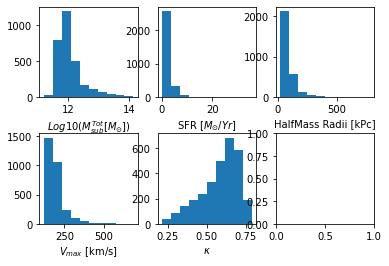

In [14]:
fig,ax = plt.subplots(2,3)

plt.subplots_adjust(hspace = 0.4)

ax[0,0].hist(np.log10(properties[:,2]))
ax[0,0].set_xlabel('$Log10(M_{sub}^{Tot} [M_{\odot}$])')

ax[0,1].hist(properties[:,3])
ax[0,1].set_xlabel('SFR [$M_{\odot} / Yr$]')

ax[0,2].hist(properties[:,4])
ax[0,2].set_xlabel('HalfMass Radii [kPc]')

ax[1,0].hist(properties[:,11])
ax[1,0].set_xlabel('$V_{max}$ [km/s]')

ax[1,1].hist(properties[:,15])
ax[1,1].set_xlabel('$\\kappa$')

In [15]:
# Let's fit an NFW to the profiles
results = np.zeros((len(labels), 3))
plot = False
# Ejemplo de uso:
for i in tqdm(range(len(labels))):
    # Obtener datos
    r = R_bins
    mass = labels[i,0,:]
    
    # Ajustar NFW
    M200, c200 = fit_NFW(r, mass)
    results[i,0] = M200
    results[i,1] = c200
    results[i,2] = np.sum((np.log10(mass) - np.log10(NFW_mass(r, M200, c200)))**2)
    
    # Graficar
    if plot:
        plt.figure()
        plt.plot(r, mass, 'o', label='Datos')
        plt.plot(r, NFW_mass(r, M200, c200), '-', label='NFW')
        plt.xscale('log')
        plt.yscale('log') 
        plt.xlabel('r [kpc]')
        plt.ylabel('M(<r) [Msun]')
        plt.title(f'M200={M200:.2e} Msun, c200={c200:.1f}')
        plt.legend()

100%|██████████████████████████████| 2972/2972 [00:04<00:00, 612.30it/s]


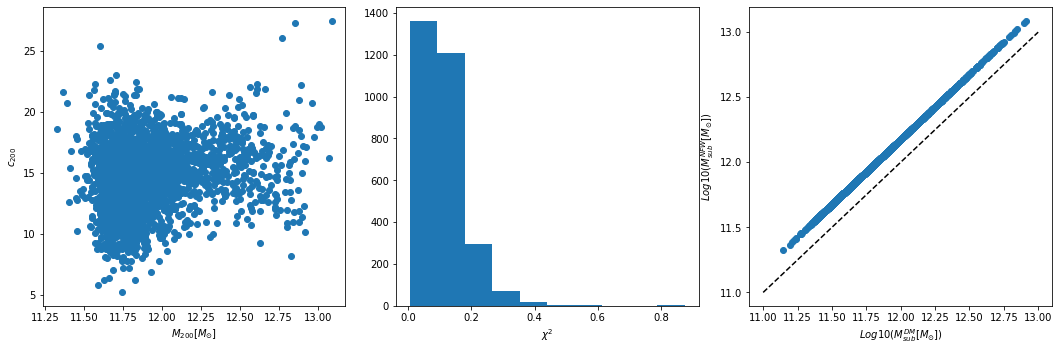

In [16]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(15, 5)
fig.tight_layout(pad=2.0)

ax[0].scatter(np.log10(results[:,0]), results[:,1])
ax[0].set_xlabel('$M_{200} [M_{\odot}]$')
ax[0].set_ylabel('$c_{200}$')
ax[1].hist(results[:,2])
ax[1].set_xlabel('$\chi^2$')

ax[2].scatter(np.log10(labels[:,0,19]), np.log10(results[:,0]))
ax[2].set_xlabel('$Log10(M_{sub}^{DM} [M_{\odot}$])')
ax[2].set_ylabel('$Log10(M_{sub}^{NFW} [M_{\odot}$])')
ax[2].plot([11,13], [11,13], 'k--')


Ratio promedio M_sub/M_NFW: 0.667
Desviación estándar: 0.000


Text(0, 0.5, 'Número')

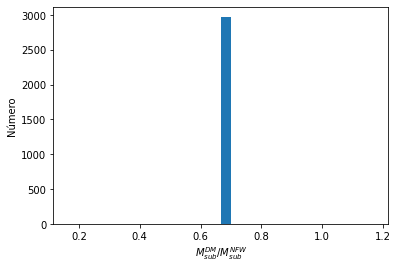

In [18]:
# Let's estimate the ratio between M_sub y M_NFW
ratio = labels[:,0,19] / results[:,0]

# Mostrar estadísticas básicas
print(f"Ratio promedio M_sub/M_NFW: {np.mean(ratio):.3f}")
print(f"Desviación estándar: {np.std(ratio):.3f}")

# Graficar histograma del ratio
plt.figure()
plt.hist(ratio, bins=30)
plt.xlabel('$M_{sub}^{DM}/M_{sub}^{NFW}$')
plt.ylabel('Número')

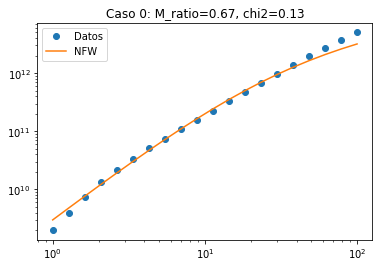

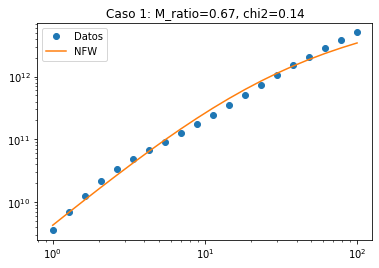

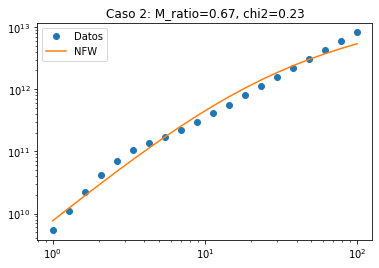

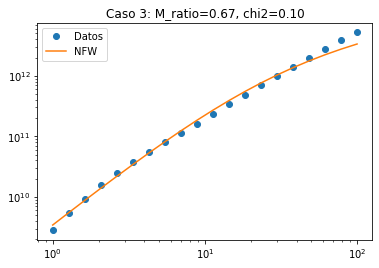

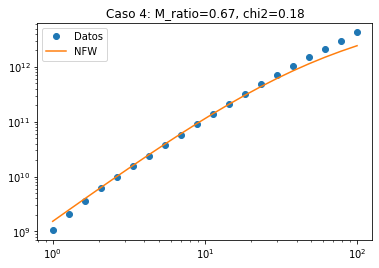

In [19]:
# Let's check some individual galaxies
for i in range(5):  # Mostrar primeros 5 casos
    plt.figure()
    plt.plot(R_bins, labels[i,0,:], 'o', label='Datos')
    plt.plot(R_bins, NFW_mass(R_bins, results[i,0], results[i,1]), '-', label='NFW')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Caso {i}: M_ratio={ratio[i]:.2f}, chi2={results[i,2]:.2f}')
    plt.legend()

<Figure size 432x288 with 0 Axes>

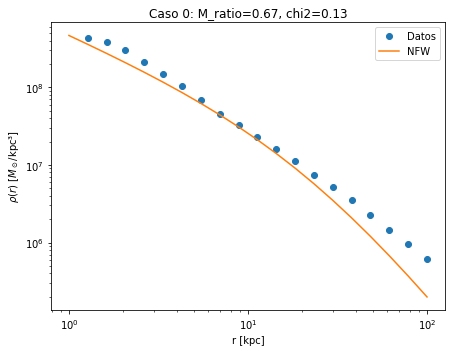

<Figure size 432x288 with 0 Axes>

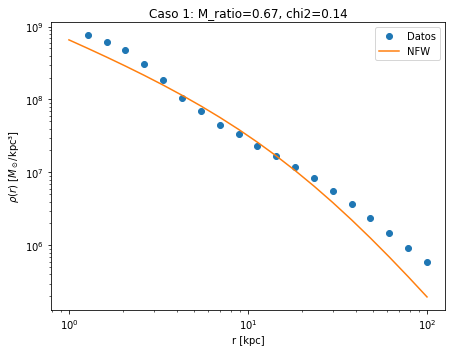

<Figure size 432x288 with 0 Axes>

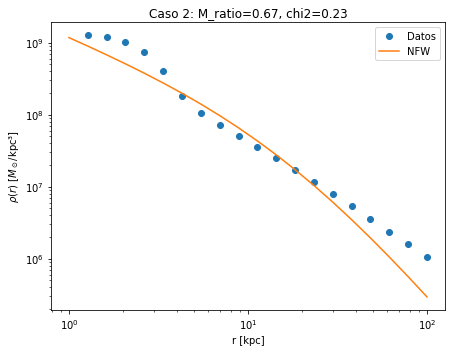

<Figure size 432x288 with 0 Axes>

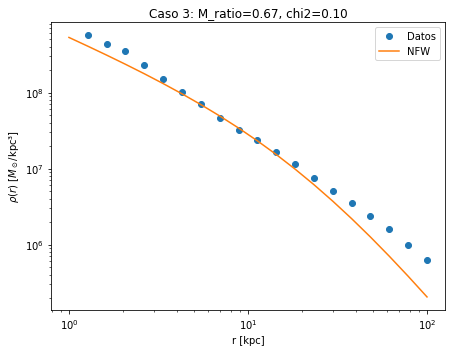

<Figure size 432x288 with 0 Axes>

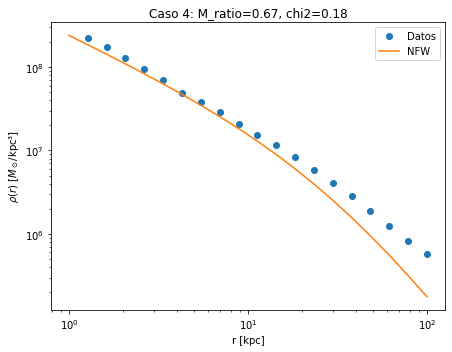

In [20]:
for i in range(5):  # Mostrar primeros 5 casos
    plt.figure()
    # Ejemplo de uso:
    plt.figure(figsize=(12,5))

    # Para los datos observados
    r = R_bins
    mass = labels[i,0,:] # Tomando la primera galaxia como ejemplo
    rho_mean, rho_local = mass_to_density(r, mass)

    # Para el perfil NFW ajustado
    rho_s = NFW_density(r, results[i,0], results[i,1])


    # Plotear densidad local
    plt.subplot(122)
    plt.plot(r[1:], rho_local, 'o', label='Datos')
    plt.plot(r, rho_s, '-', label='NFW')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('r [kpc]')
    plt.ylabel('$\\rho(r)$ [$M_\\odot$/kpc³]')
    plt.title(f'Caso {i}: M_ratio={ratio[i]:.2f}, chi2={results[i,2]:.2f}')
    plt.legend()

    plt.tight_layout()

In [21]:
plt.figure(figsize=(10,5))

R200 = (3 * results[:,0] / (4 * np.pi * 200 * rho_crit))**(1/3)

# Comparar con el radio máximo de los datos
R_max = R_bins[-1]  # típicamente 100 kpc
plt.hist(R200/R_max, bins=30)
plt.xlabel('R200/R_max')
plt.title('Comparación de radios característicos')

# 2. Comparar perfiles normalizados
plt.figure()
for i in range(min(100, len(labels))):  # Primeros 100 halos
    mass_norm = labels[i,0,:]/labels[i,0,-1]  # Normalizar por masa total
    plt.plot(R_bins/R_bins[-1], mass_norm, 'k-', alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r/R_max')
plt.ylabel('M(<r)/M_total')
plt.title('Perfiles de masa normalizados')

NameError: name 'rho_crit' is not defined

<Figure size 720x360 with 0 Axes>

In [23]:
H = 67.74
3 * H**2 / (8 * np.pi * G) * 1e-6

127.38060993197922

4.3e-06

In [ ]:
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
